In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from aging.plotting import format_plots, PlotConfig, save_factory, figure, legend, format_pizza_plots
from collections import Counter
from matplotlib.lines import Line2D
from scipy.stats import zscore

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import colorcet as cc
from operator import add
from tqdm.auto import tqdm
from functools import reduce
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.spatial.distance import squareform, pdist
from sklearn.metrics import silhouette_score
from aging.plotting import format_plots, figure, save_factory, PlotConfig, legend, add_identity

In [3]:
def mm_norm_col(column):
    return (column - column.min()) / (column.max() - column.min())

In [4]:
from matplotlib.colors import LinearSegmentedColormap
colors = ['#c7eae5','#008C8D']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmm=custom_cmap

image_ctx = {'image.cmap': 'cubehelix', 'image.interpolation': 'none'}

In [5]:
## arrange data
keep_syllables = np.loadtxt('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/to_keep_syllables_raw.txt', dtype=int)

male_df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/ontogeny_males_raw_usage_matrix_v00.parquet').astype(float)
male_df = male_df[keep_syllables]

# avarage per age or session
m_df = male_df.groupby(['age','uuid']).mean()
avg_m_df = m_df.groupby(['age']).mean()

# normalize the data
m_norm = mm_norm_col(m_df)
avg_m_norm = mm_norm_col(avg_m_df)

# zscore
z_m = m_df.apply(zscore, axis=0)
avg_z_m = avg_m_df.apply(zscore, axis=0)

# log
m_log = np.log(m_df+1e-3)
avg_m_log = np.log(avg_m_df+1e-3)

# sort syllable order by the average
syll_sort_m = (
    avg_m_norm.rolling(5, center=True, win_type="exponential")
    .mean(tau=1.5)
    .idxmax()
    .sort_values()
    .index
)


In [6]:
## arrange data
keep_syllables = np.loadtxt('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/to_keep_syllables_raw.txt', dtype=int)

female_df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/ontogeny_females_raw_usage_matrix_v00.parquet').astype(float)
female_df = female_df[keep_syllables]

# for female:
f_df= female_df.groupby(['age','uuid']).mean()
# Update age value to 52 for rows with uuid in the list
uuids = ['f1d5dce5-f5cf-4b03-b07d-d9b8c1f034b0','6fa50ac7-6d49-4ef9-9059-3d90bdd8c5d4',
         'e9e05da8-fc59-40f3-a9c8-f57c492c6141','327e7fa1-2237-43d2-b25f-c1801912df33',
        '242bee8e-0ee7-45e7-8a13-678836a4cddb','552ec70f-0676-4471-8ab0-403e1fcf43e3','d6f254af-d55a-427a-96e0-c452a233cbe2']
f_df.reset_index(inplace=True)

age_mapping = {
    93: 94,
    95: 94,
    97: 98,
    98: 98,
    102: 98,
    103: 105,
    105: 105,
    107: 105
}

f_df['age'] = f_df['age'].map(age_mapping).fillna(f_df['age'])
f_df.loc[f_df['uuid'].isin(uuids), 'age'] = 52
# Set the index back
f_df.set_index(['age', 'uuid'], inplace=True)
f_df=f_df.query('age<127')

In [7]:
# avarage per age or session
f_df = f_df.groupby(['age','uuid']).mean()
avg_f_df = f_df.groupby(['age']).mean()

# normalize the data
f_norm = mm_norm_col(f_df)
avg_f_norm = mm_norm_col(avg_f_df)

# zscore
z_f = f_df.apply(zscore, axis=0)
avg_z_f = avg_f_df.apply(zscore, axis=0)

# log
f_log = np.log(f_df+1e-3)
avg_f_log = np.log(avg_f_df+1e-3)

# sort syllable order by the average
syll_sort_f = (
    avg_f_norm.rolling(5, center=True, win_type="exponential")
    .mean(tau=1.5)
    .idxmax()
    .sort_values()
    .index
)

In [8]:
format_plots()

## H clustering

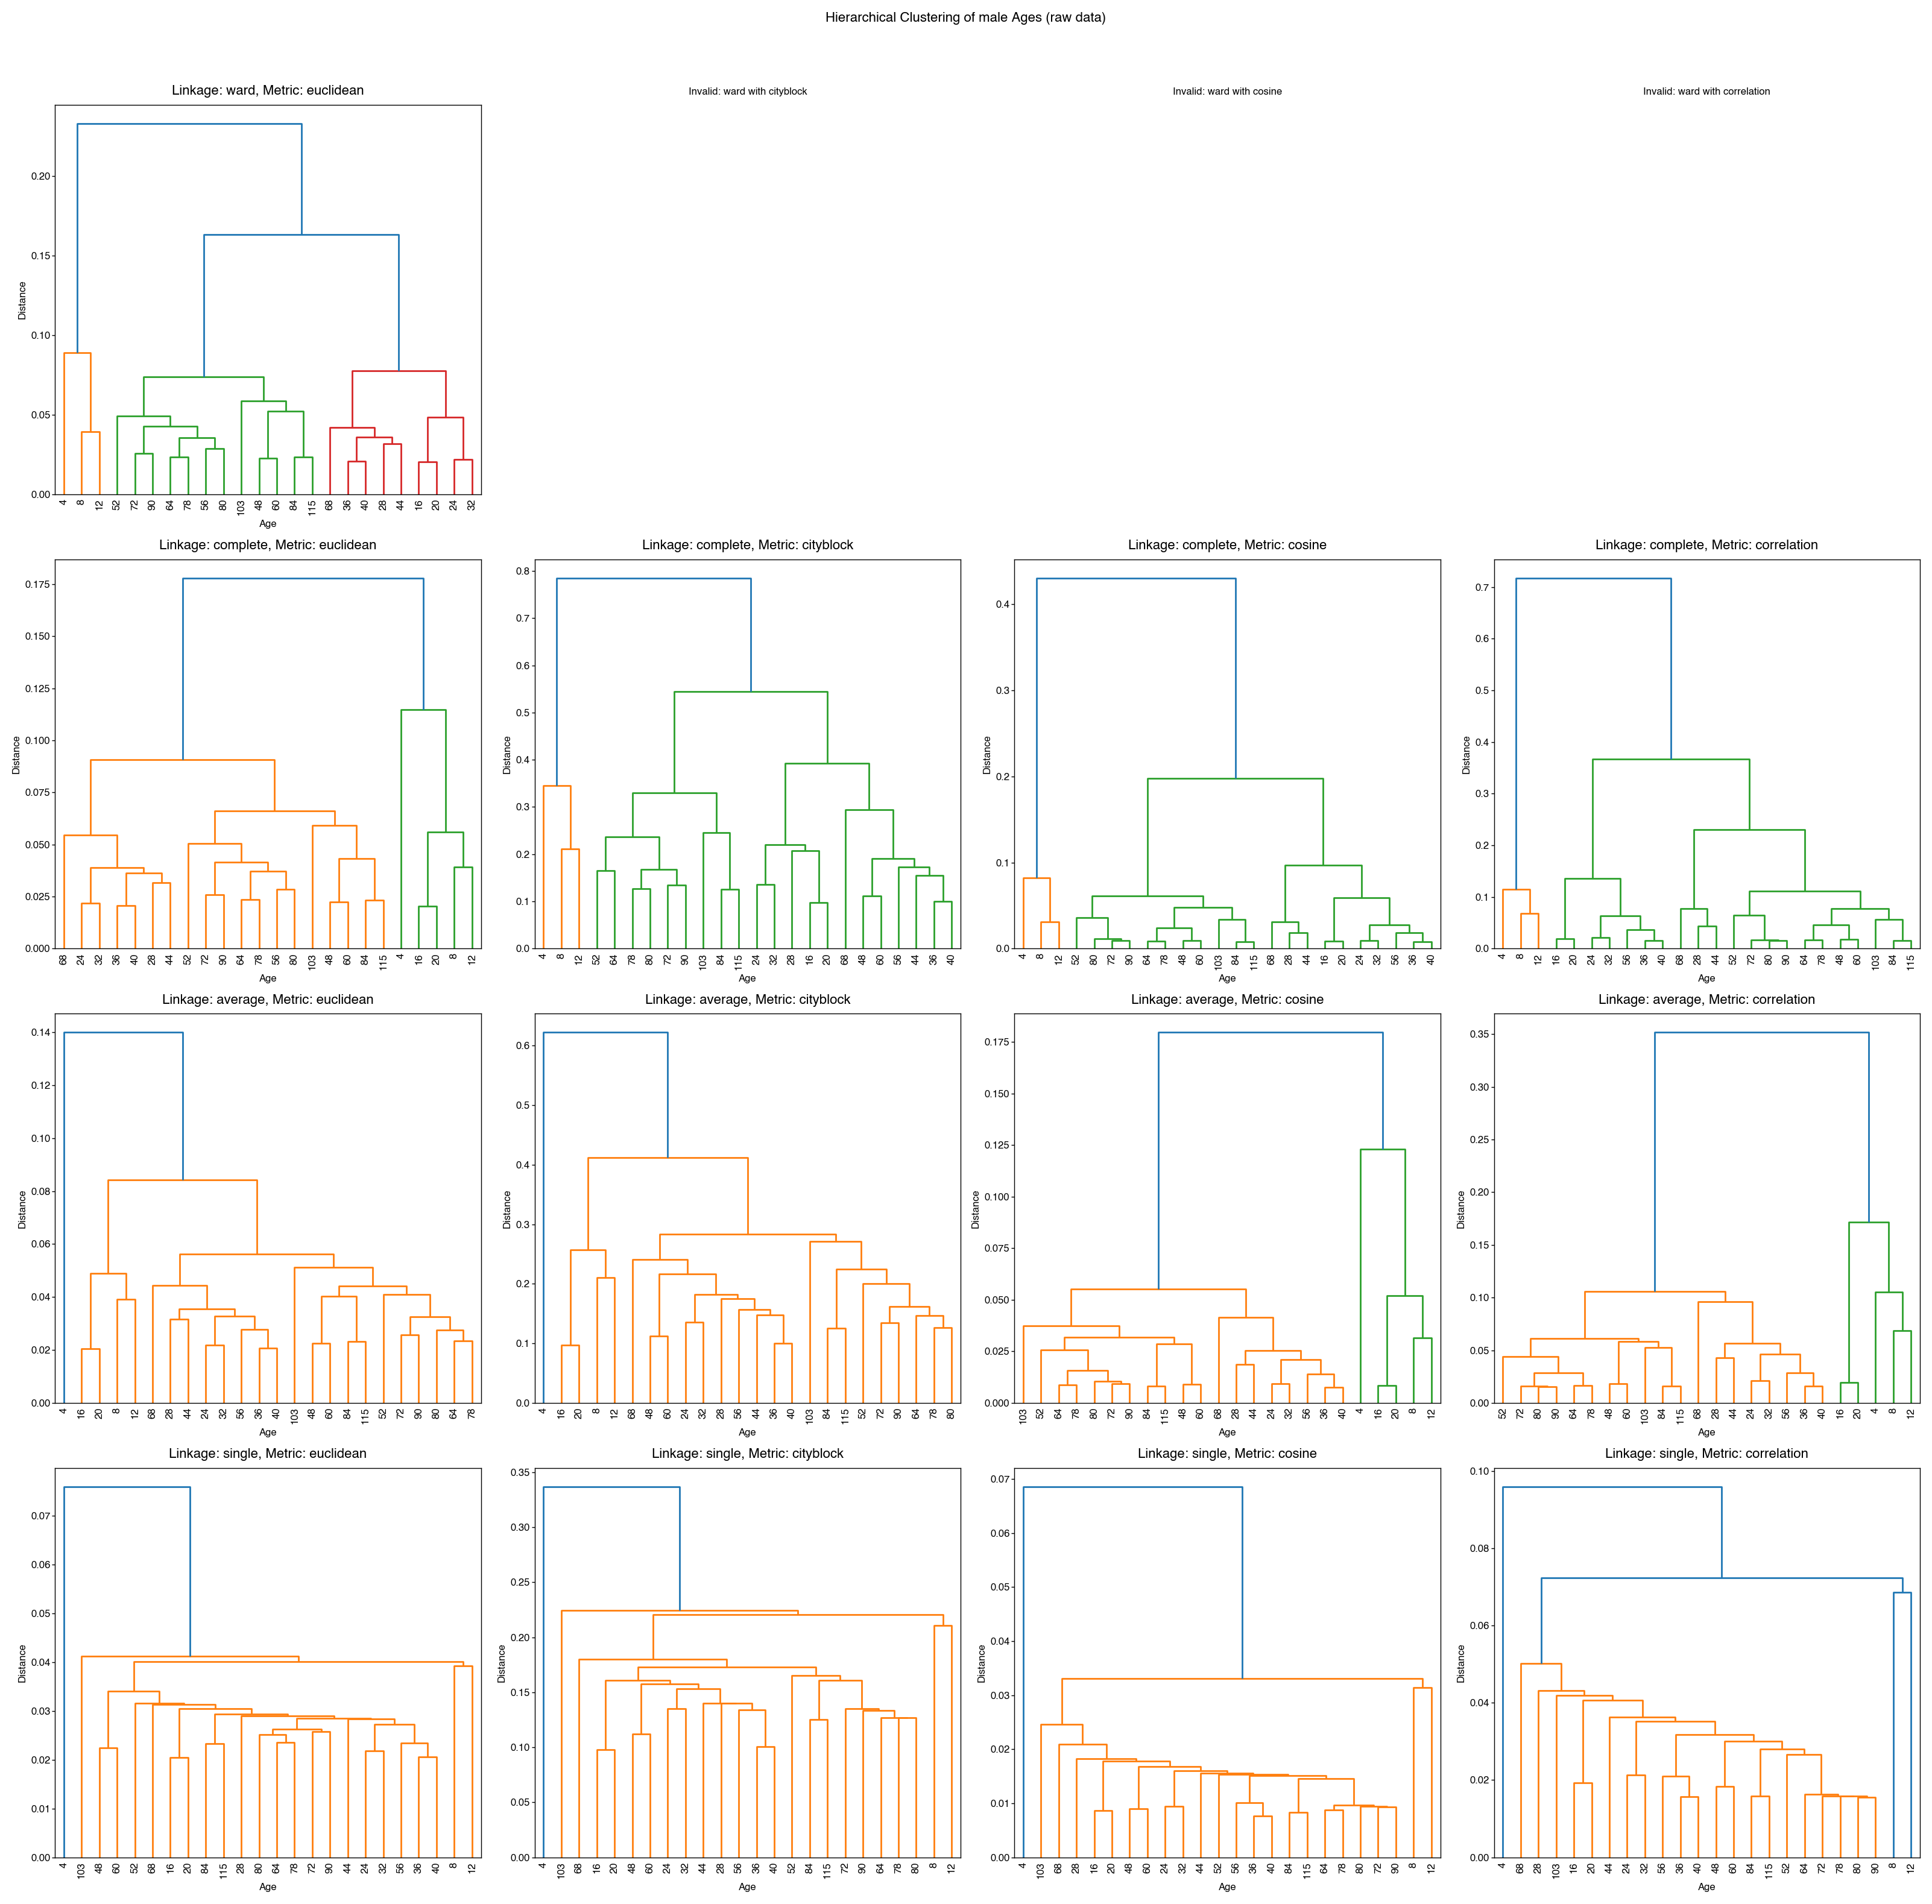

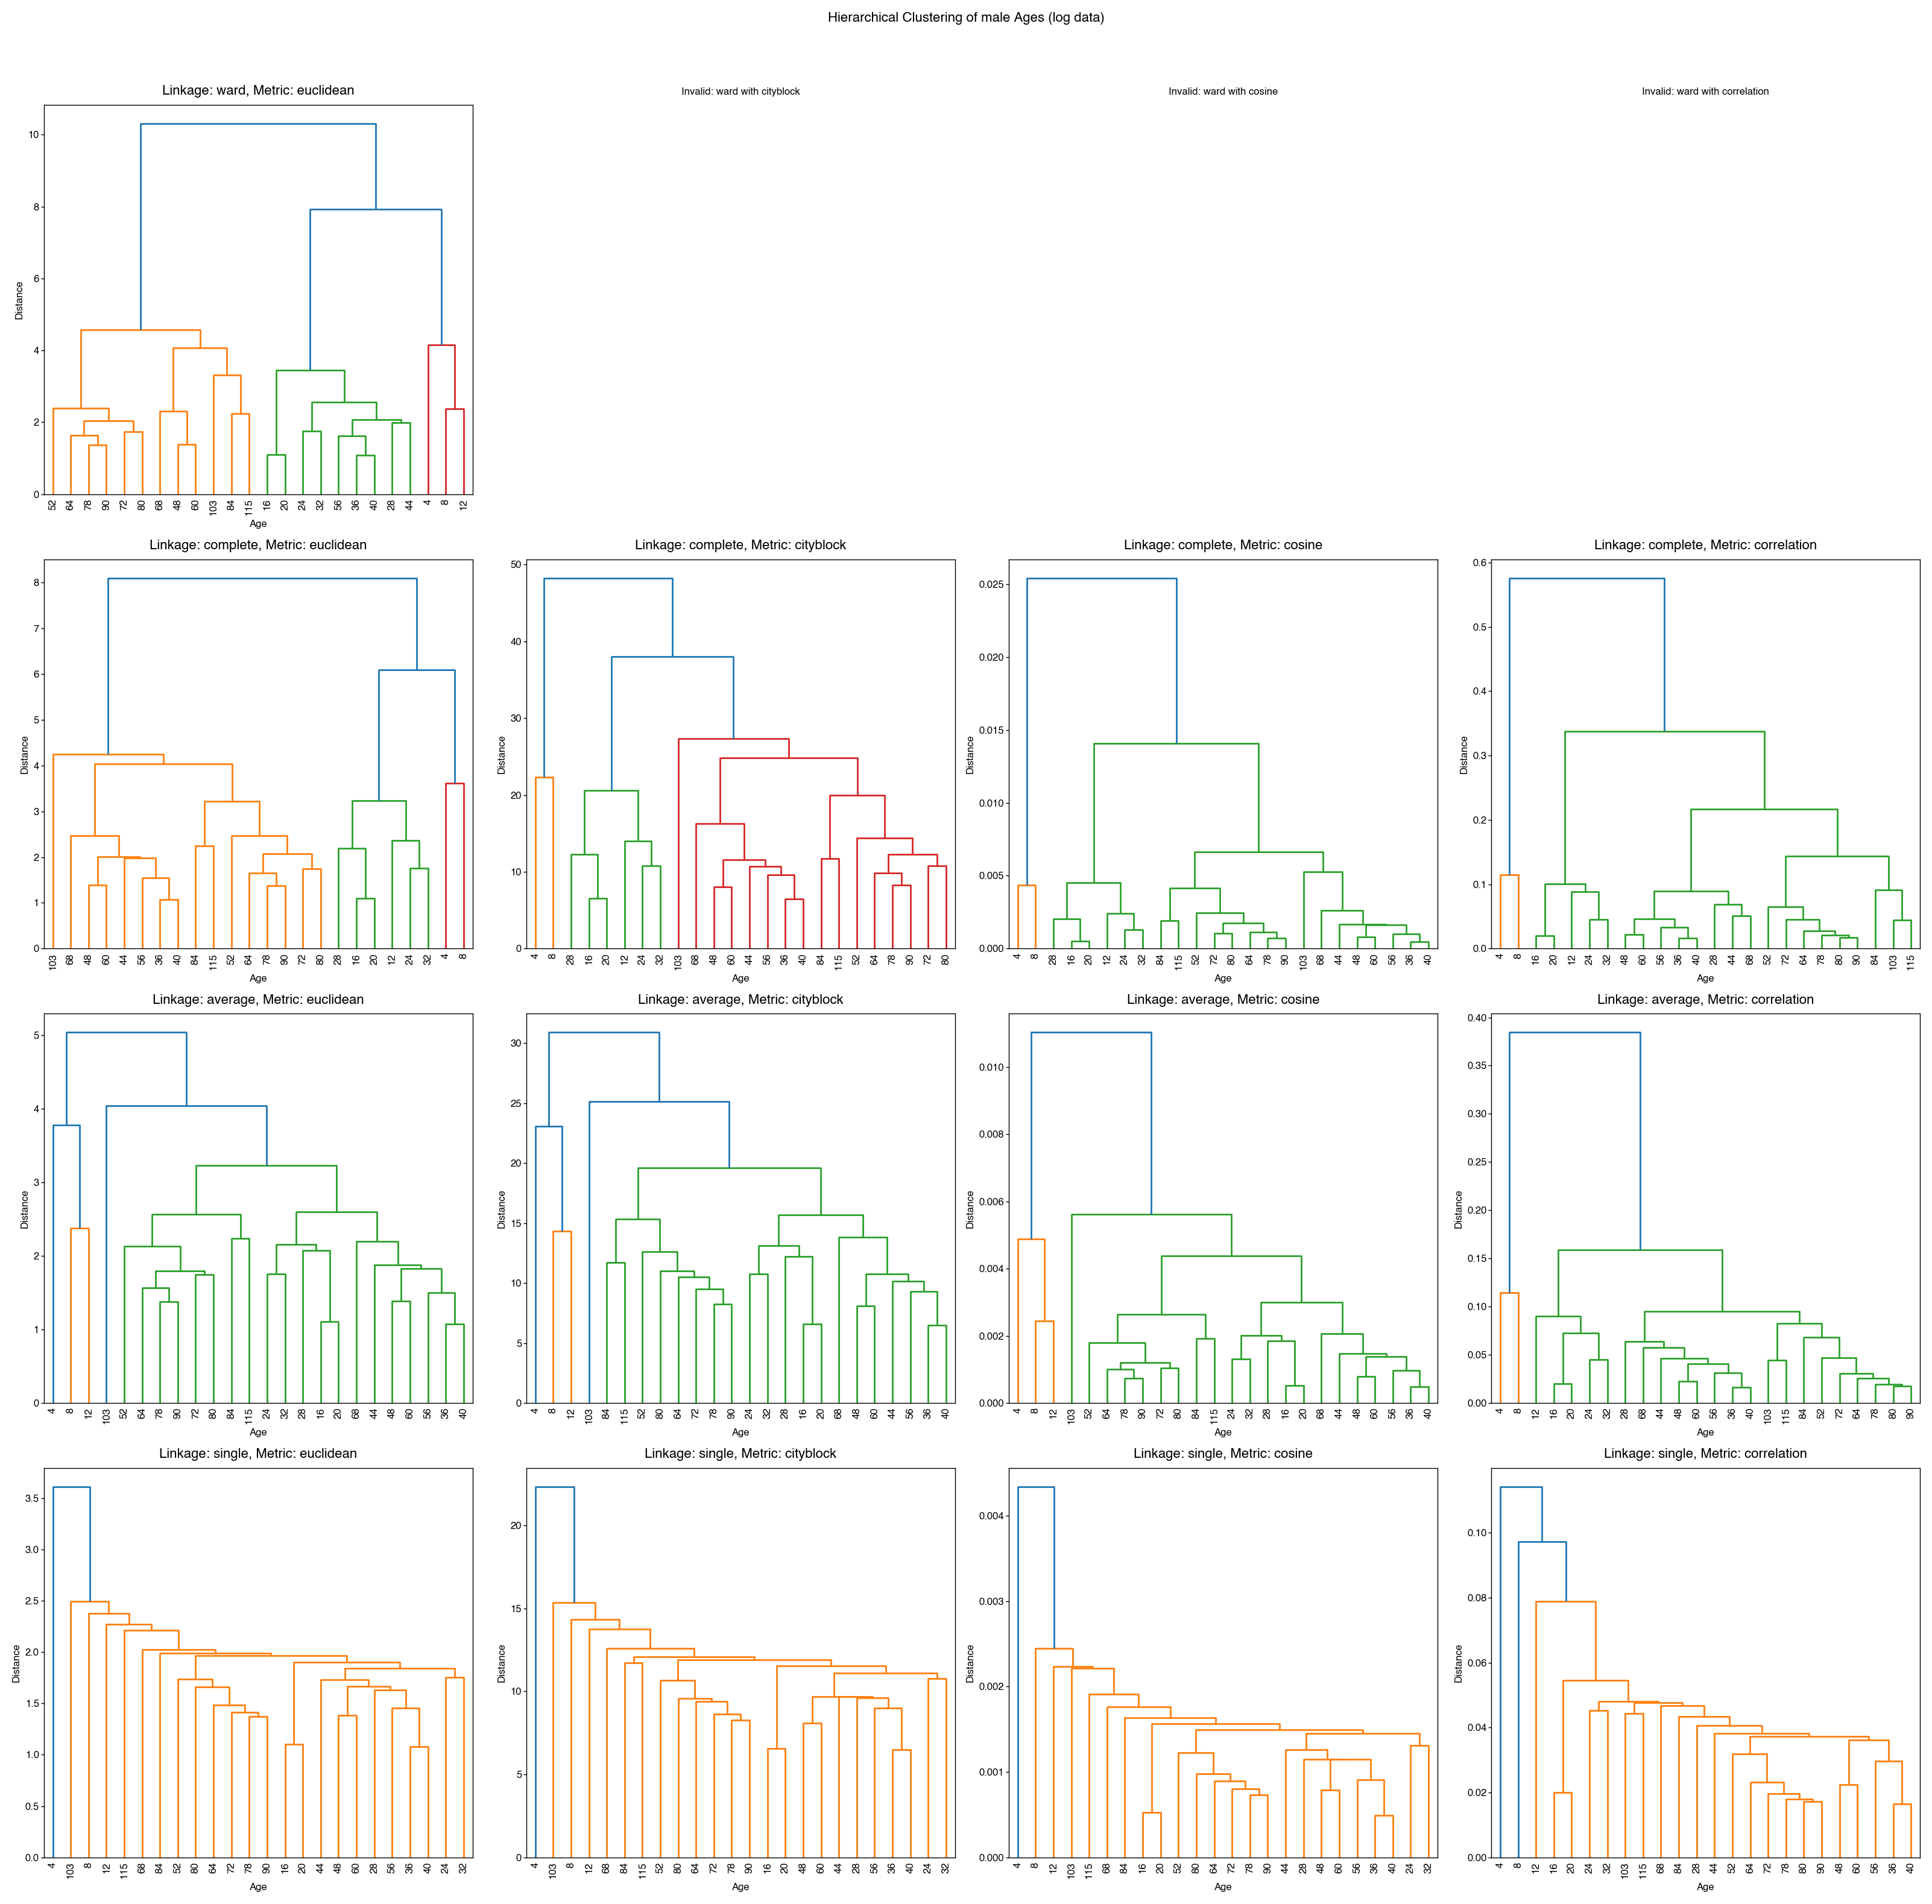

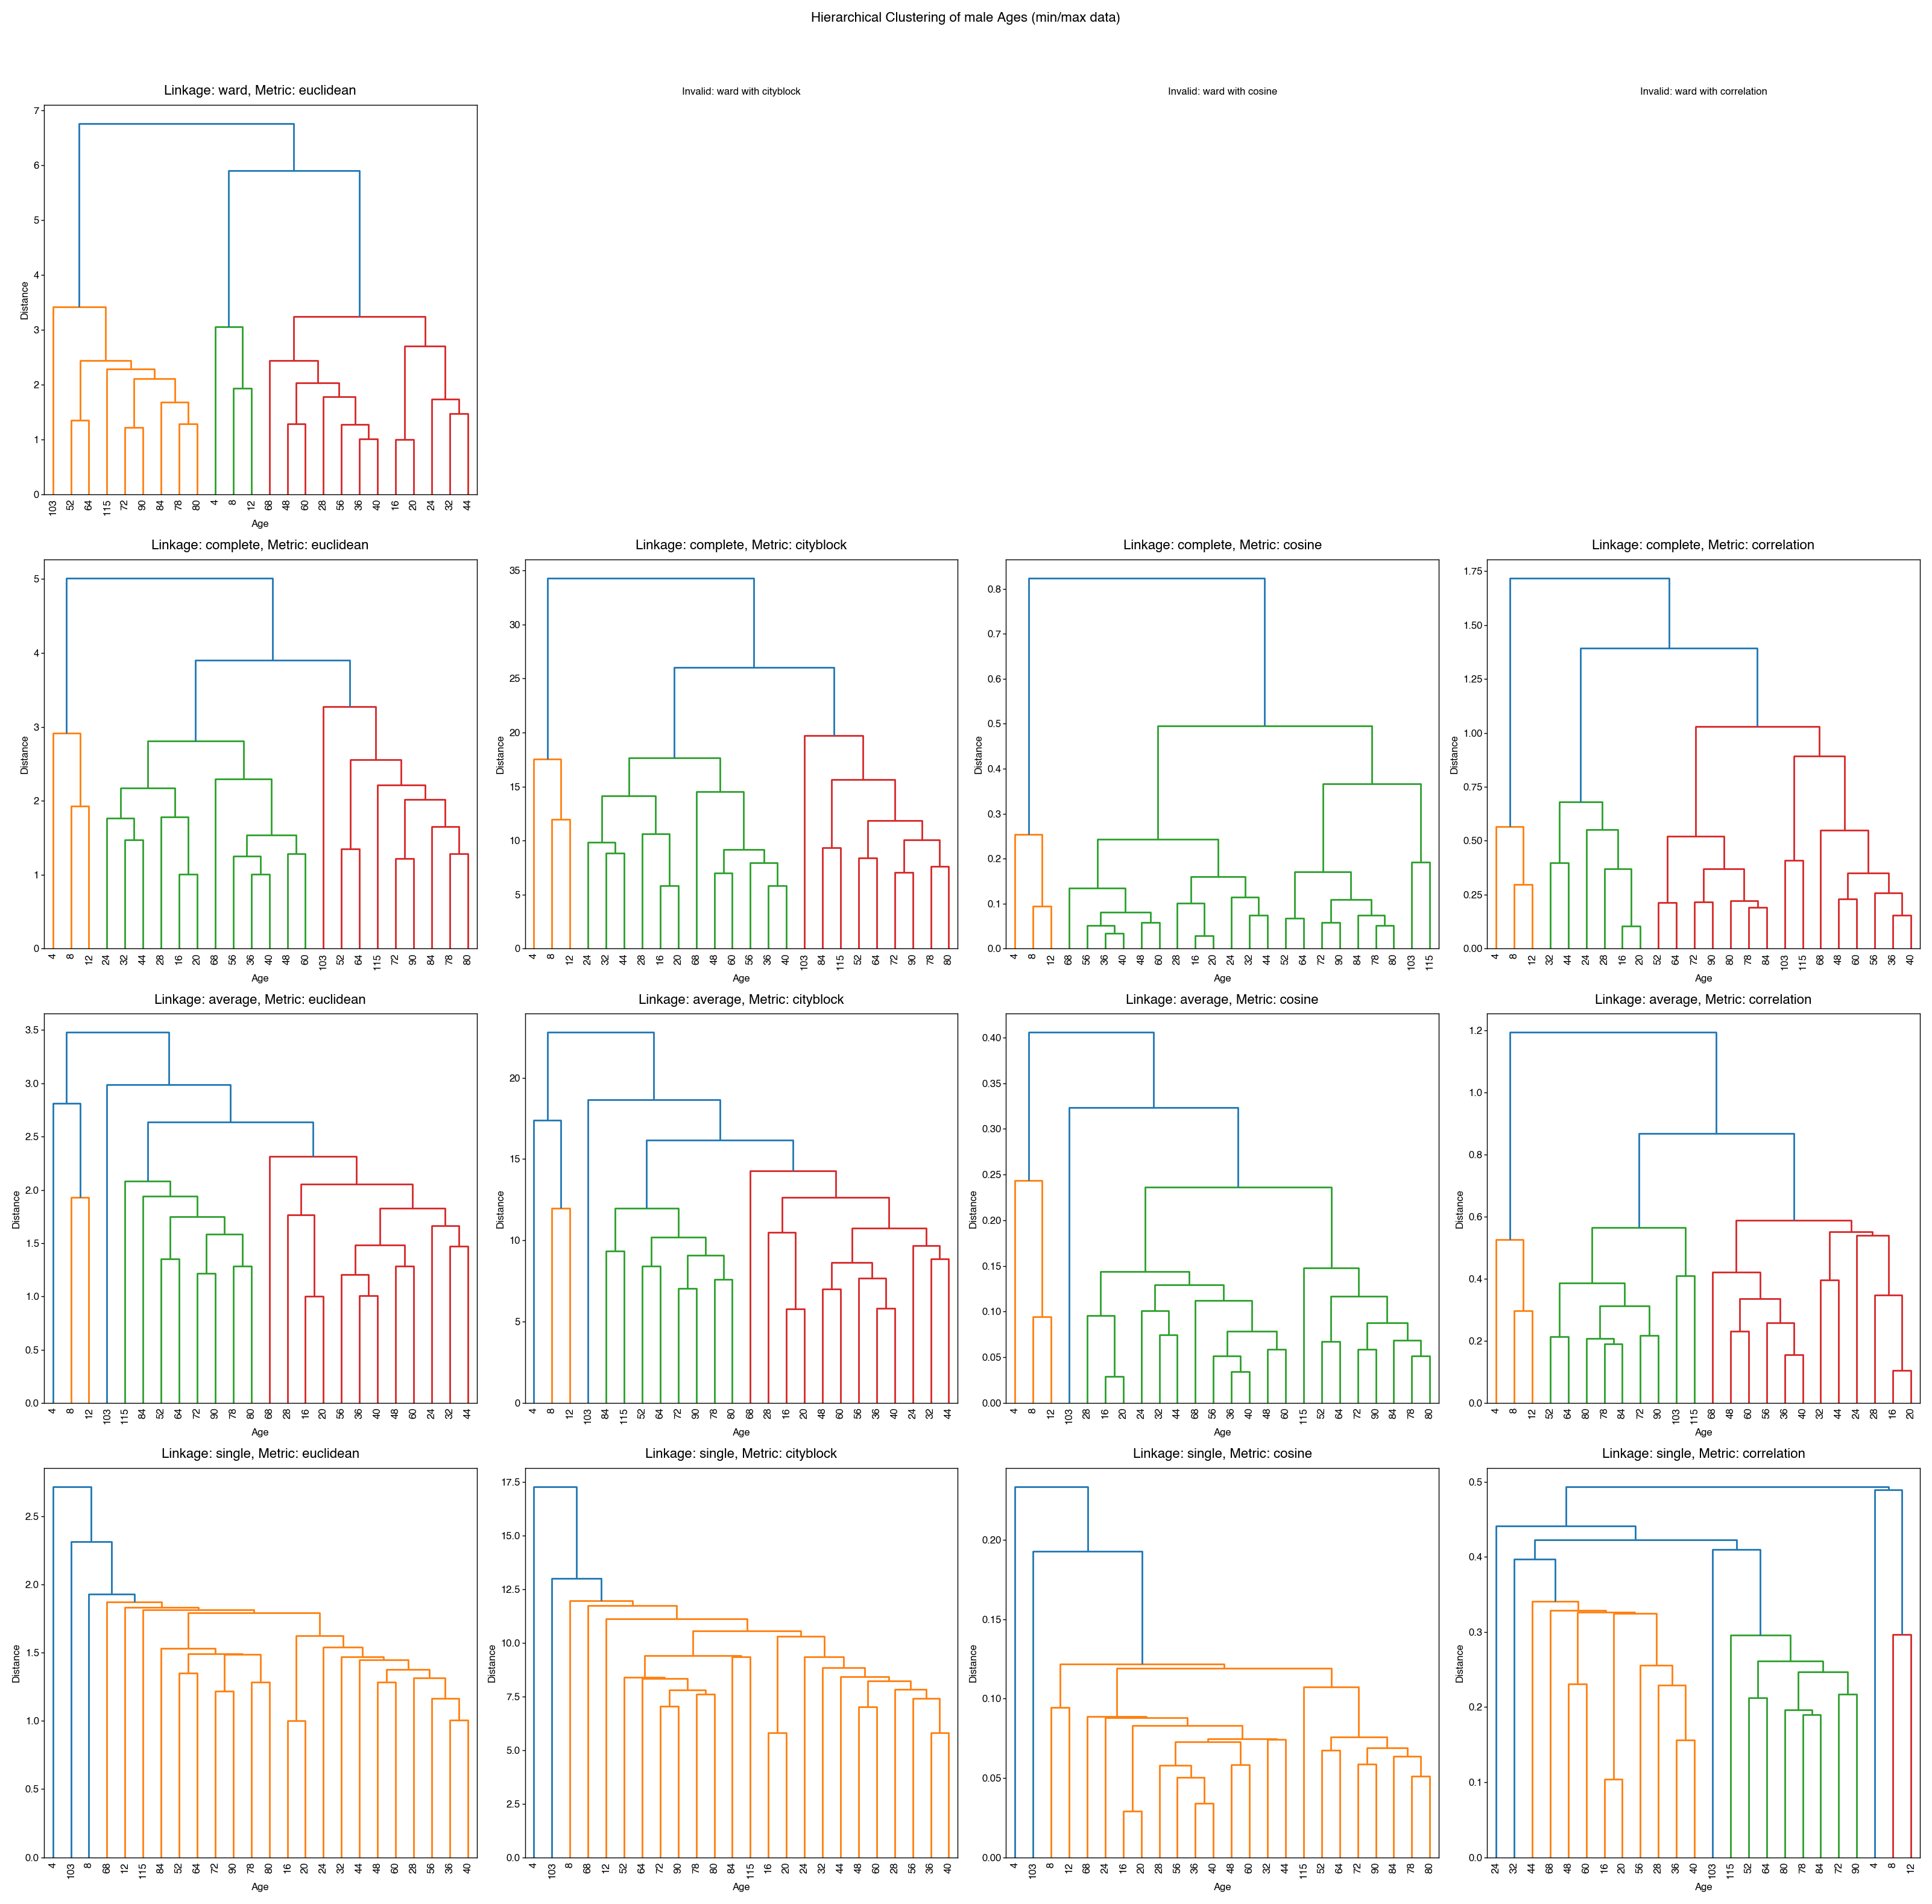

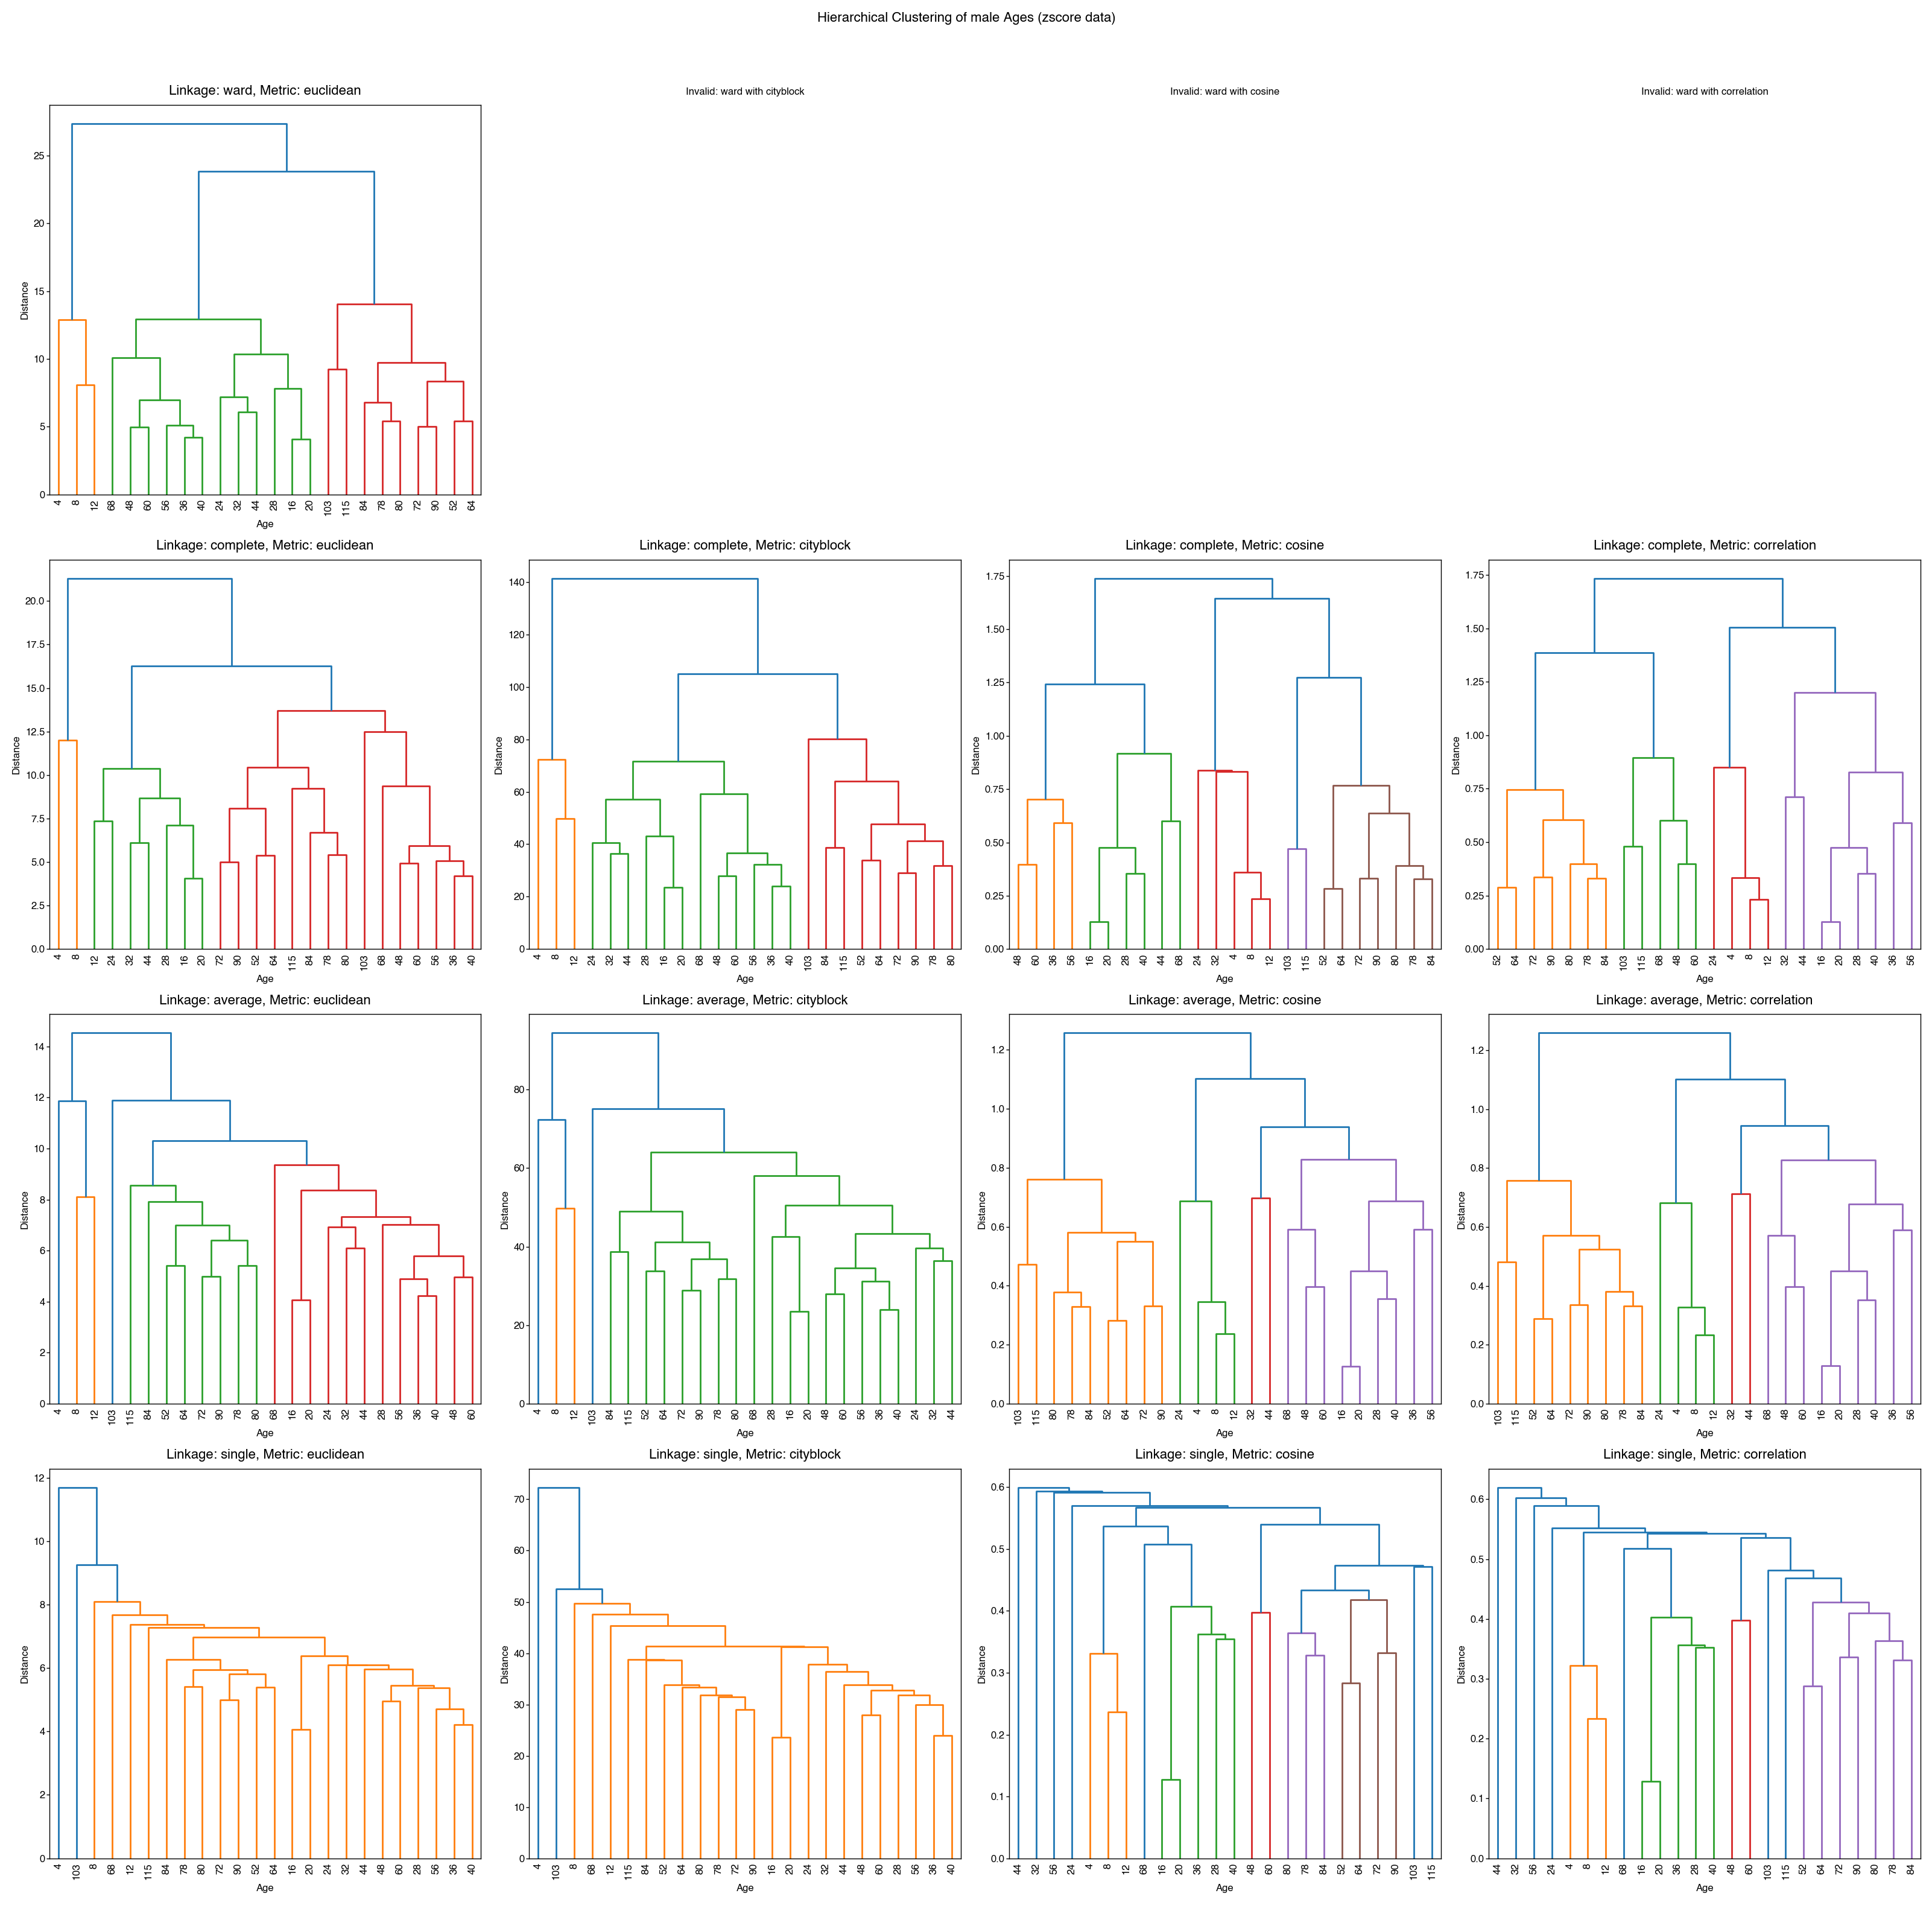

In [9]:
from scipy.cluster.hierarchy import dendrogram, linkage
dataframes = [avg_m_df, avg_m_log, avg_m_norm, avg_z_m]
data_types = ['raw', 'log', 'min/max', 'zscore']


# Parameters for hierarchical clustering
linkage_methods = ['ward', 'complete', 'average', 'single']
distance_metrics = ['euclidean', 'cityblock', 'cosine', 'correlation']

for df, data_type in zip(dataframes, data_types):
    X = df.values

    # Set up the subplot grid
    fig, axes = plt.subplots(len(linkage_methods), len(distance_metrics), figsize=(16, 16))
    fig.suptitle(f'Hierarchical Clustering of male Ages ({data_type} data)', fontsize=8)

    for i, method in enumerate(linkage_methods):
        for j, metric in enumerate(distance_metrics):
            if method == 'ward' and metric != 'euclidean':
                axes[i, j].axis('off')  # Turn off the axis if the combination is invalid
                axes[i, j].set_title(f'Invalid: {method} with {metric}', fontsize=6)
            else:
                ax = axes[i, j]
                if metric in ['cityblock', 'cosine', 'correlation']:
                    dists = pdist(X, metric=metric)
                    Z = linkage(dists, method=method)
                else:
                    Z = linkage(X, method=method, metric=metric)
                dendro = dendrogram(Z, labels=df.index.get_level_values('age'), ax=ax, leaf_rotation=90)
                ax.set_title(f'Linkage: {method}, Metric: {metric}', fontsize=8)
                ax.set_xlabel('Age', fontsize=6)
                ax.set_ylabel('Distance', fontsize=6)
                ax.tick_params(axis='x', labelsize=6)
                ax.tick_params(axis='y', labelsize=6)

    # Adjust layout
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

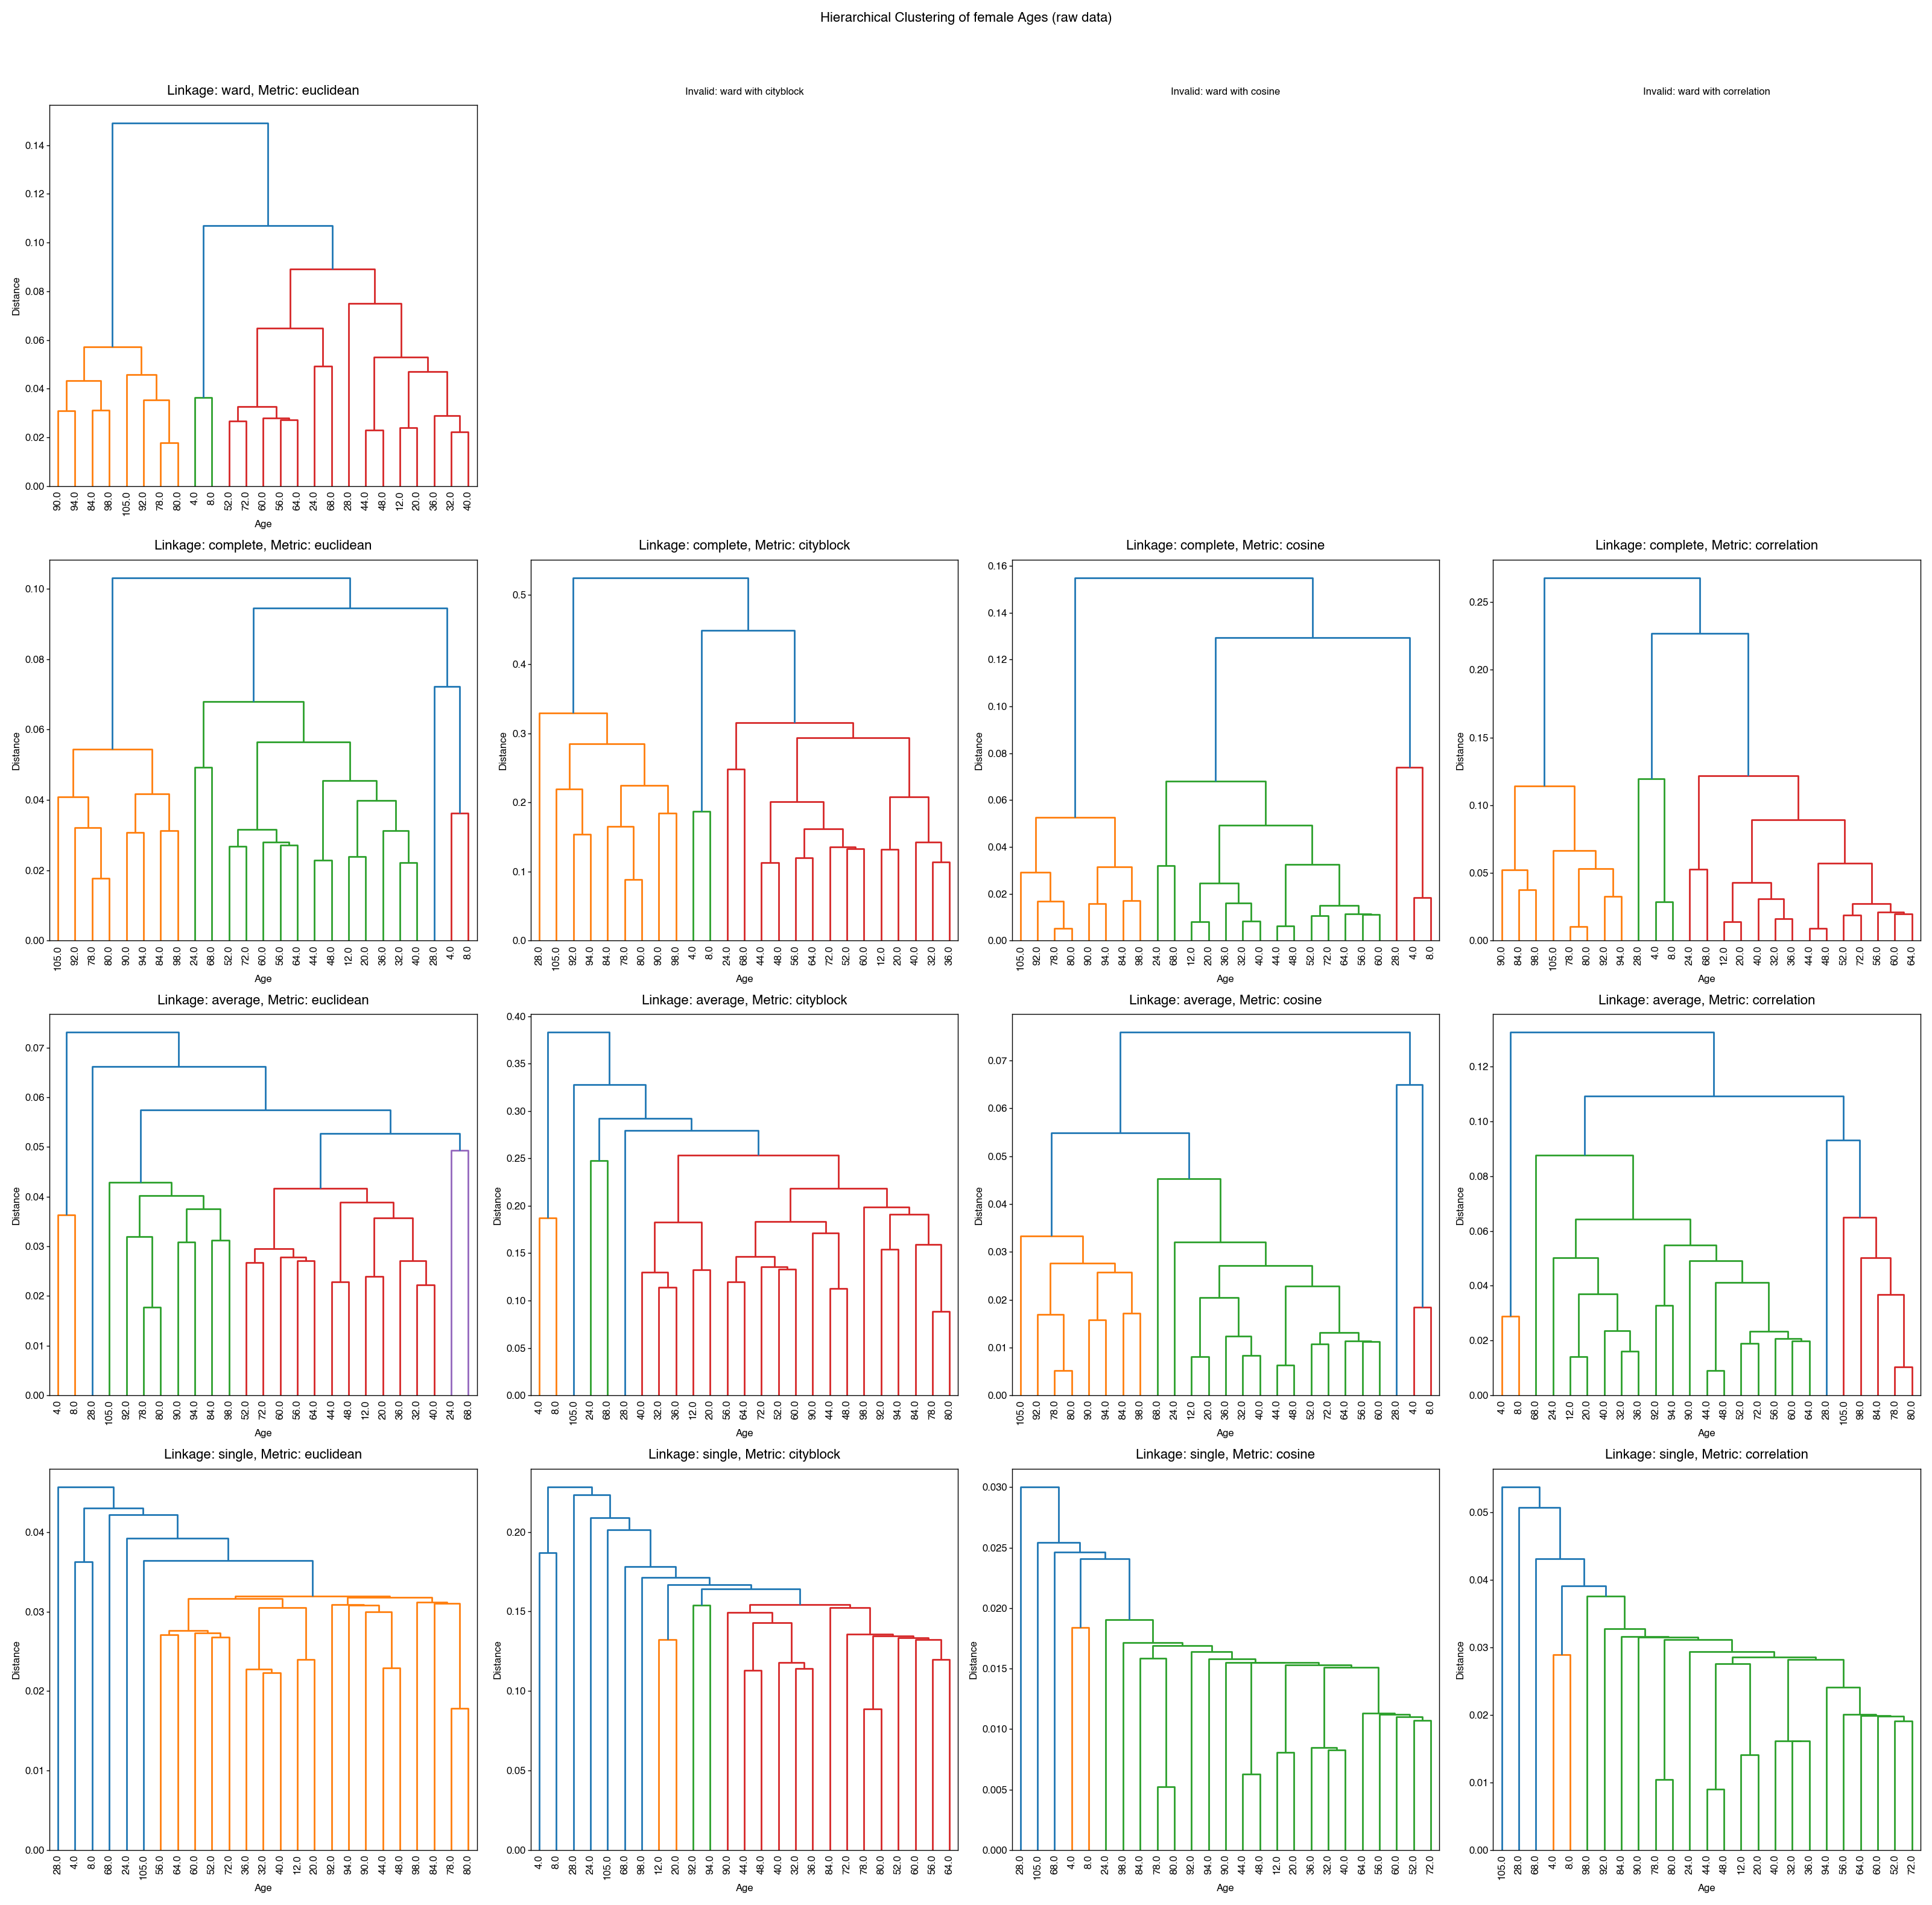

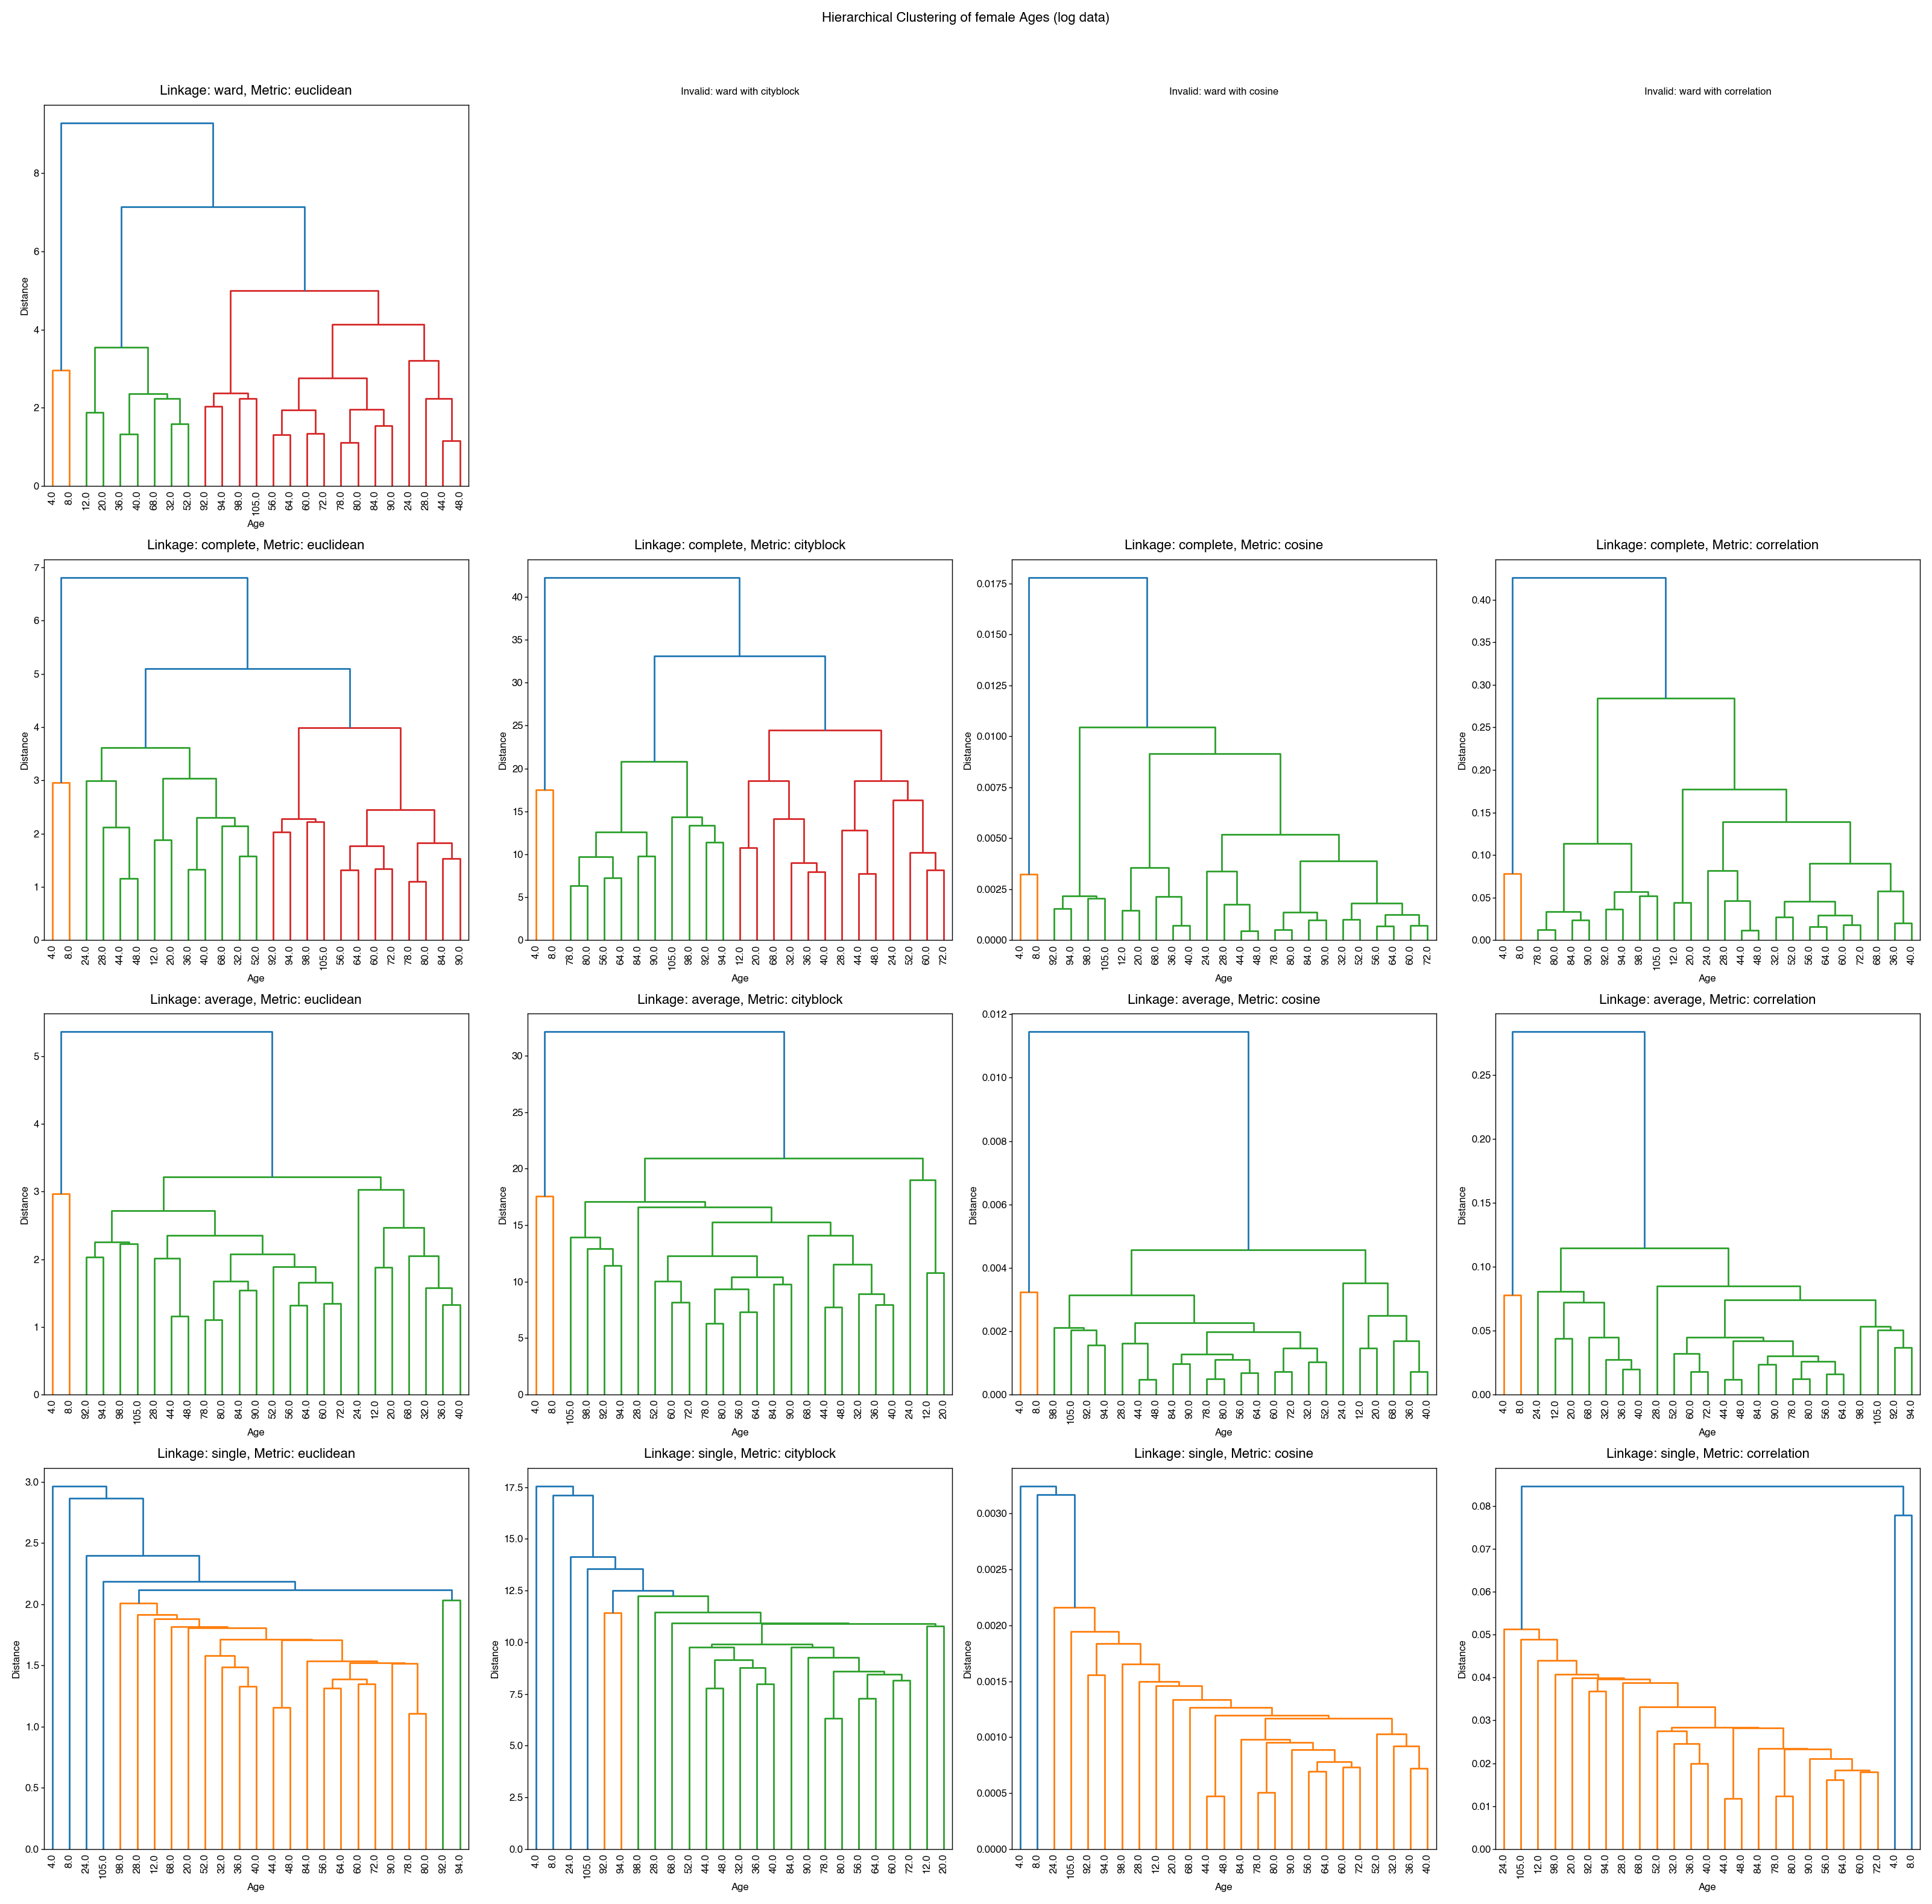

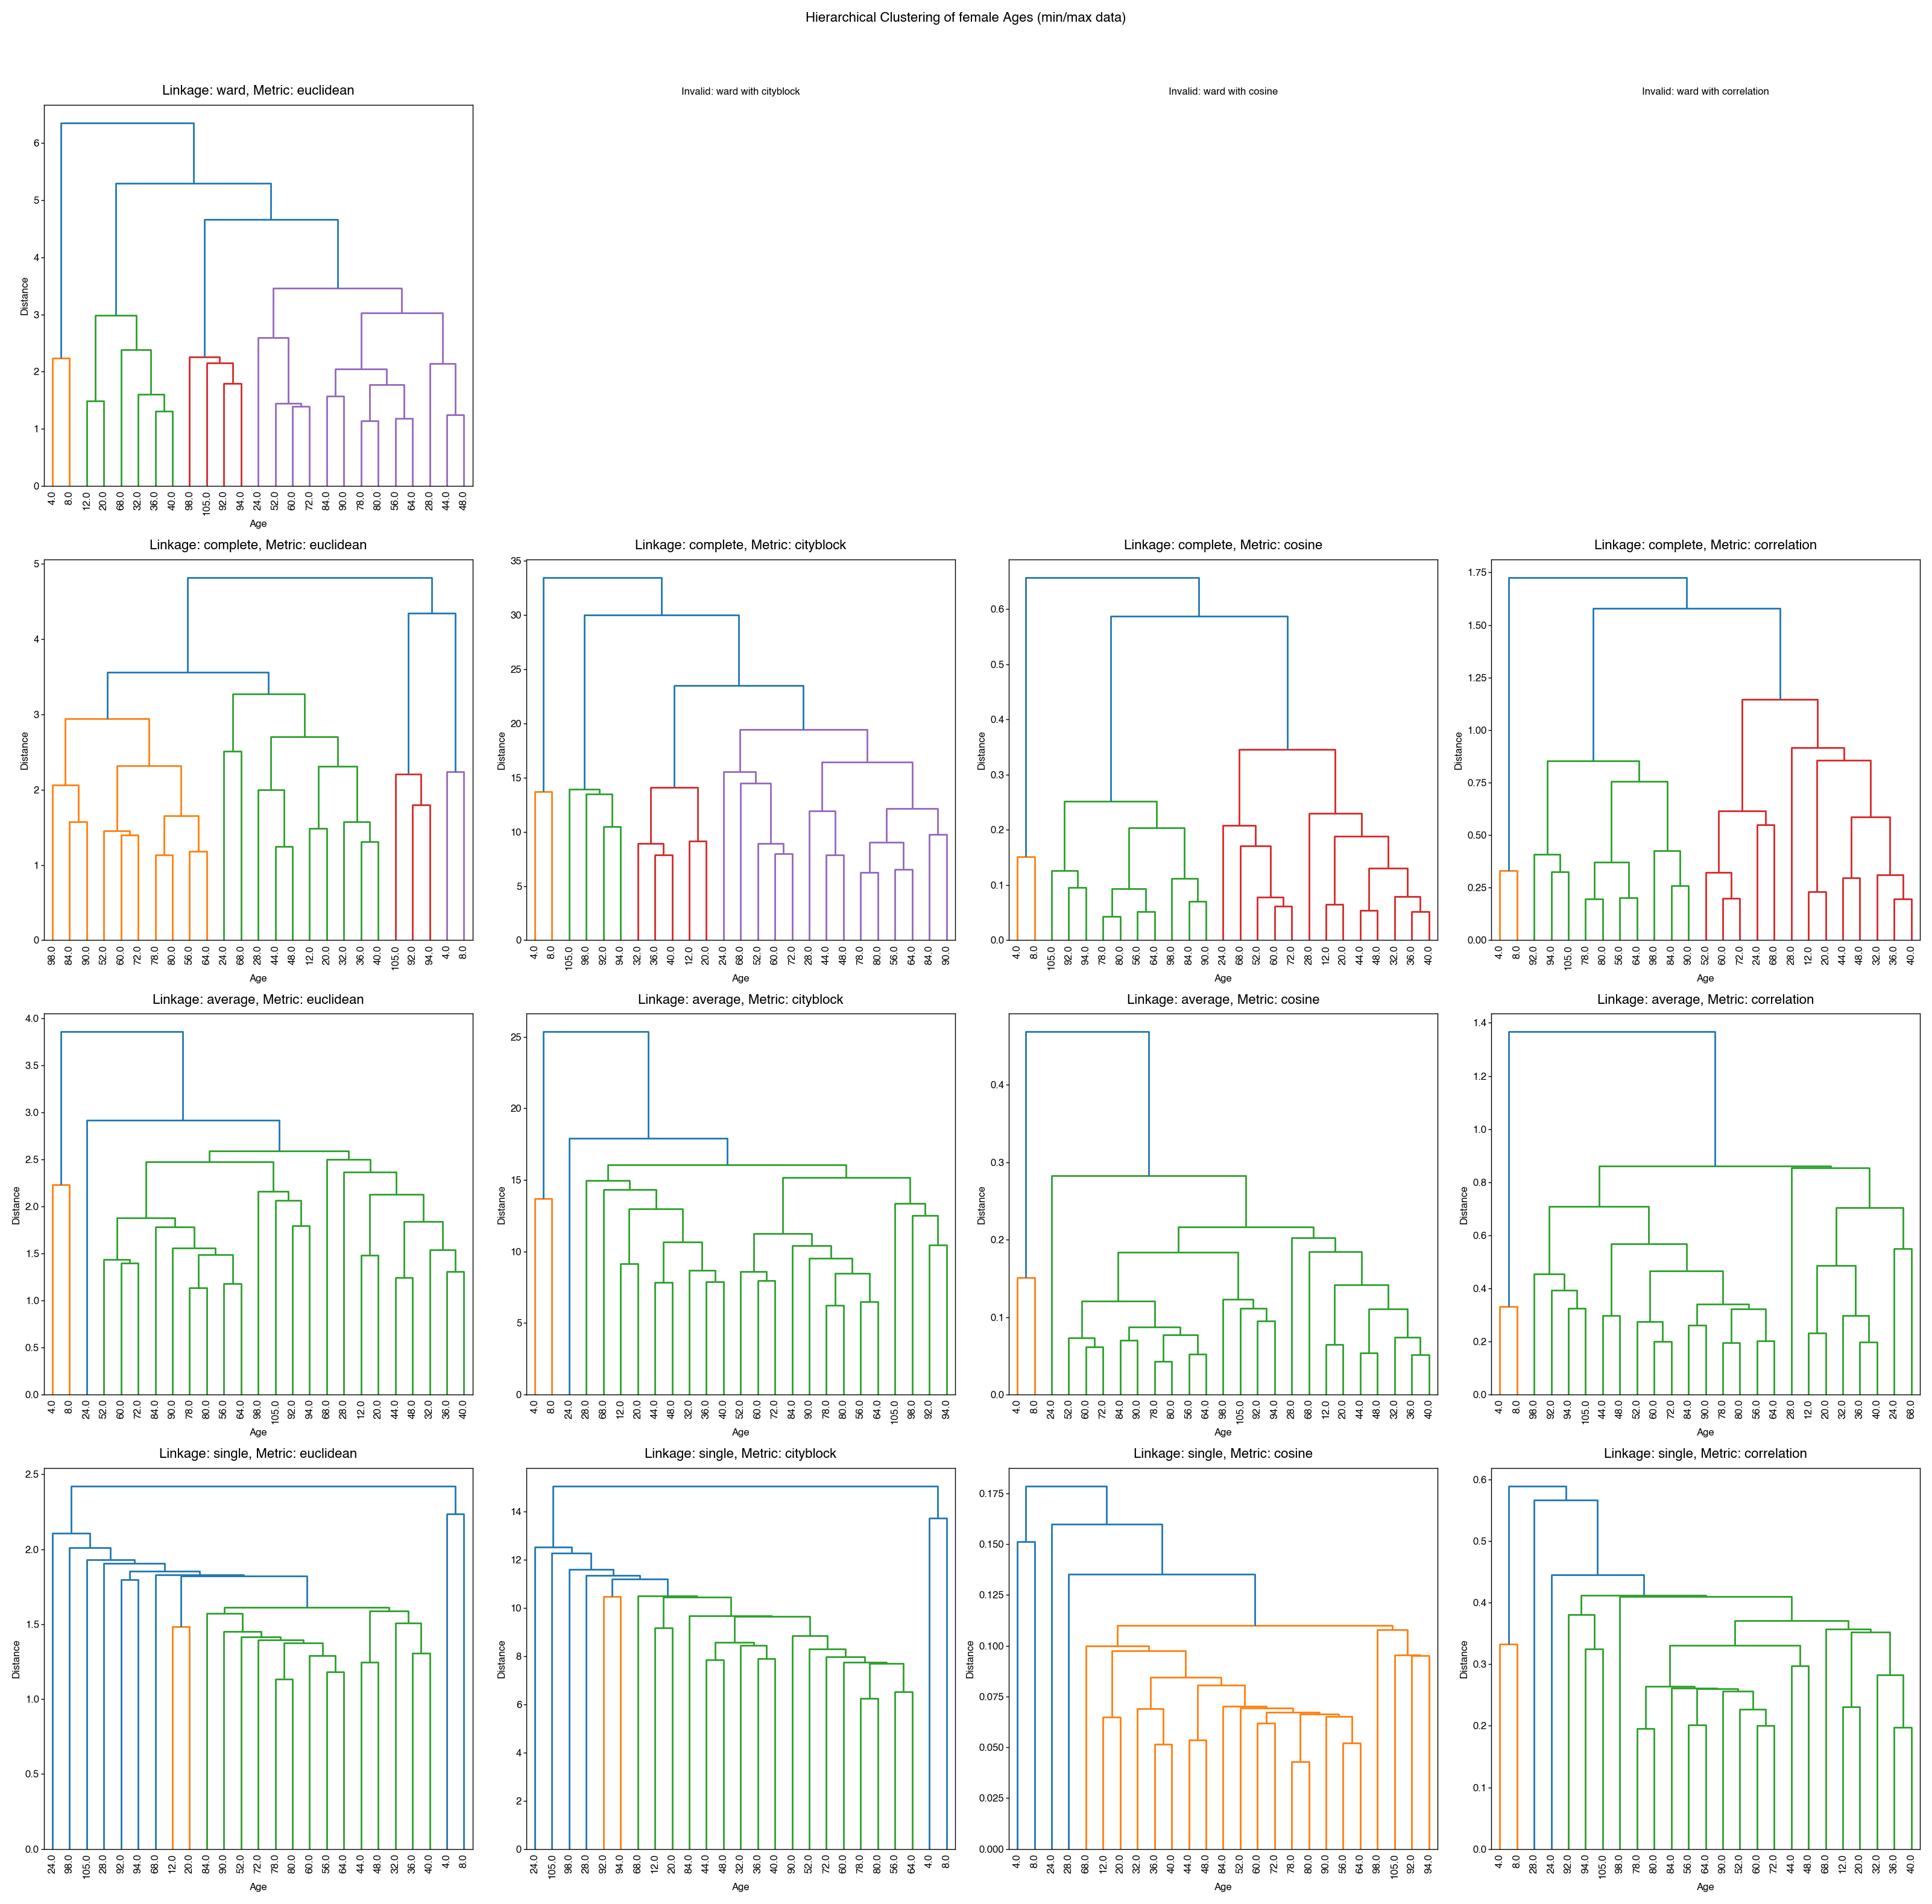

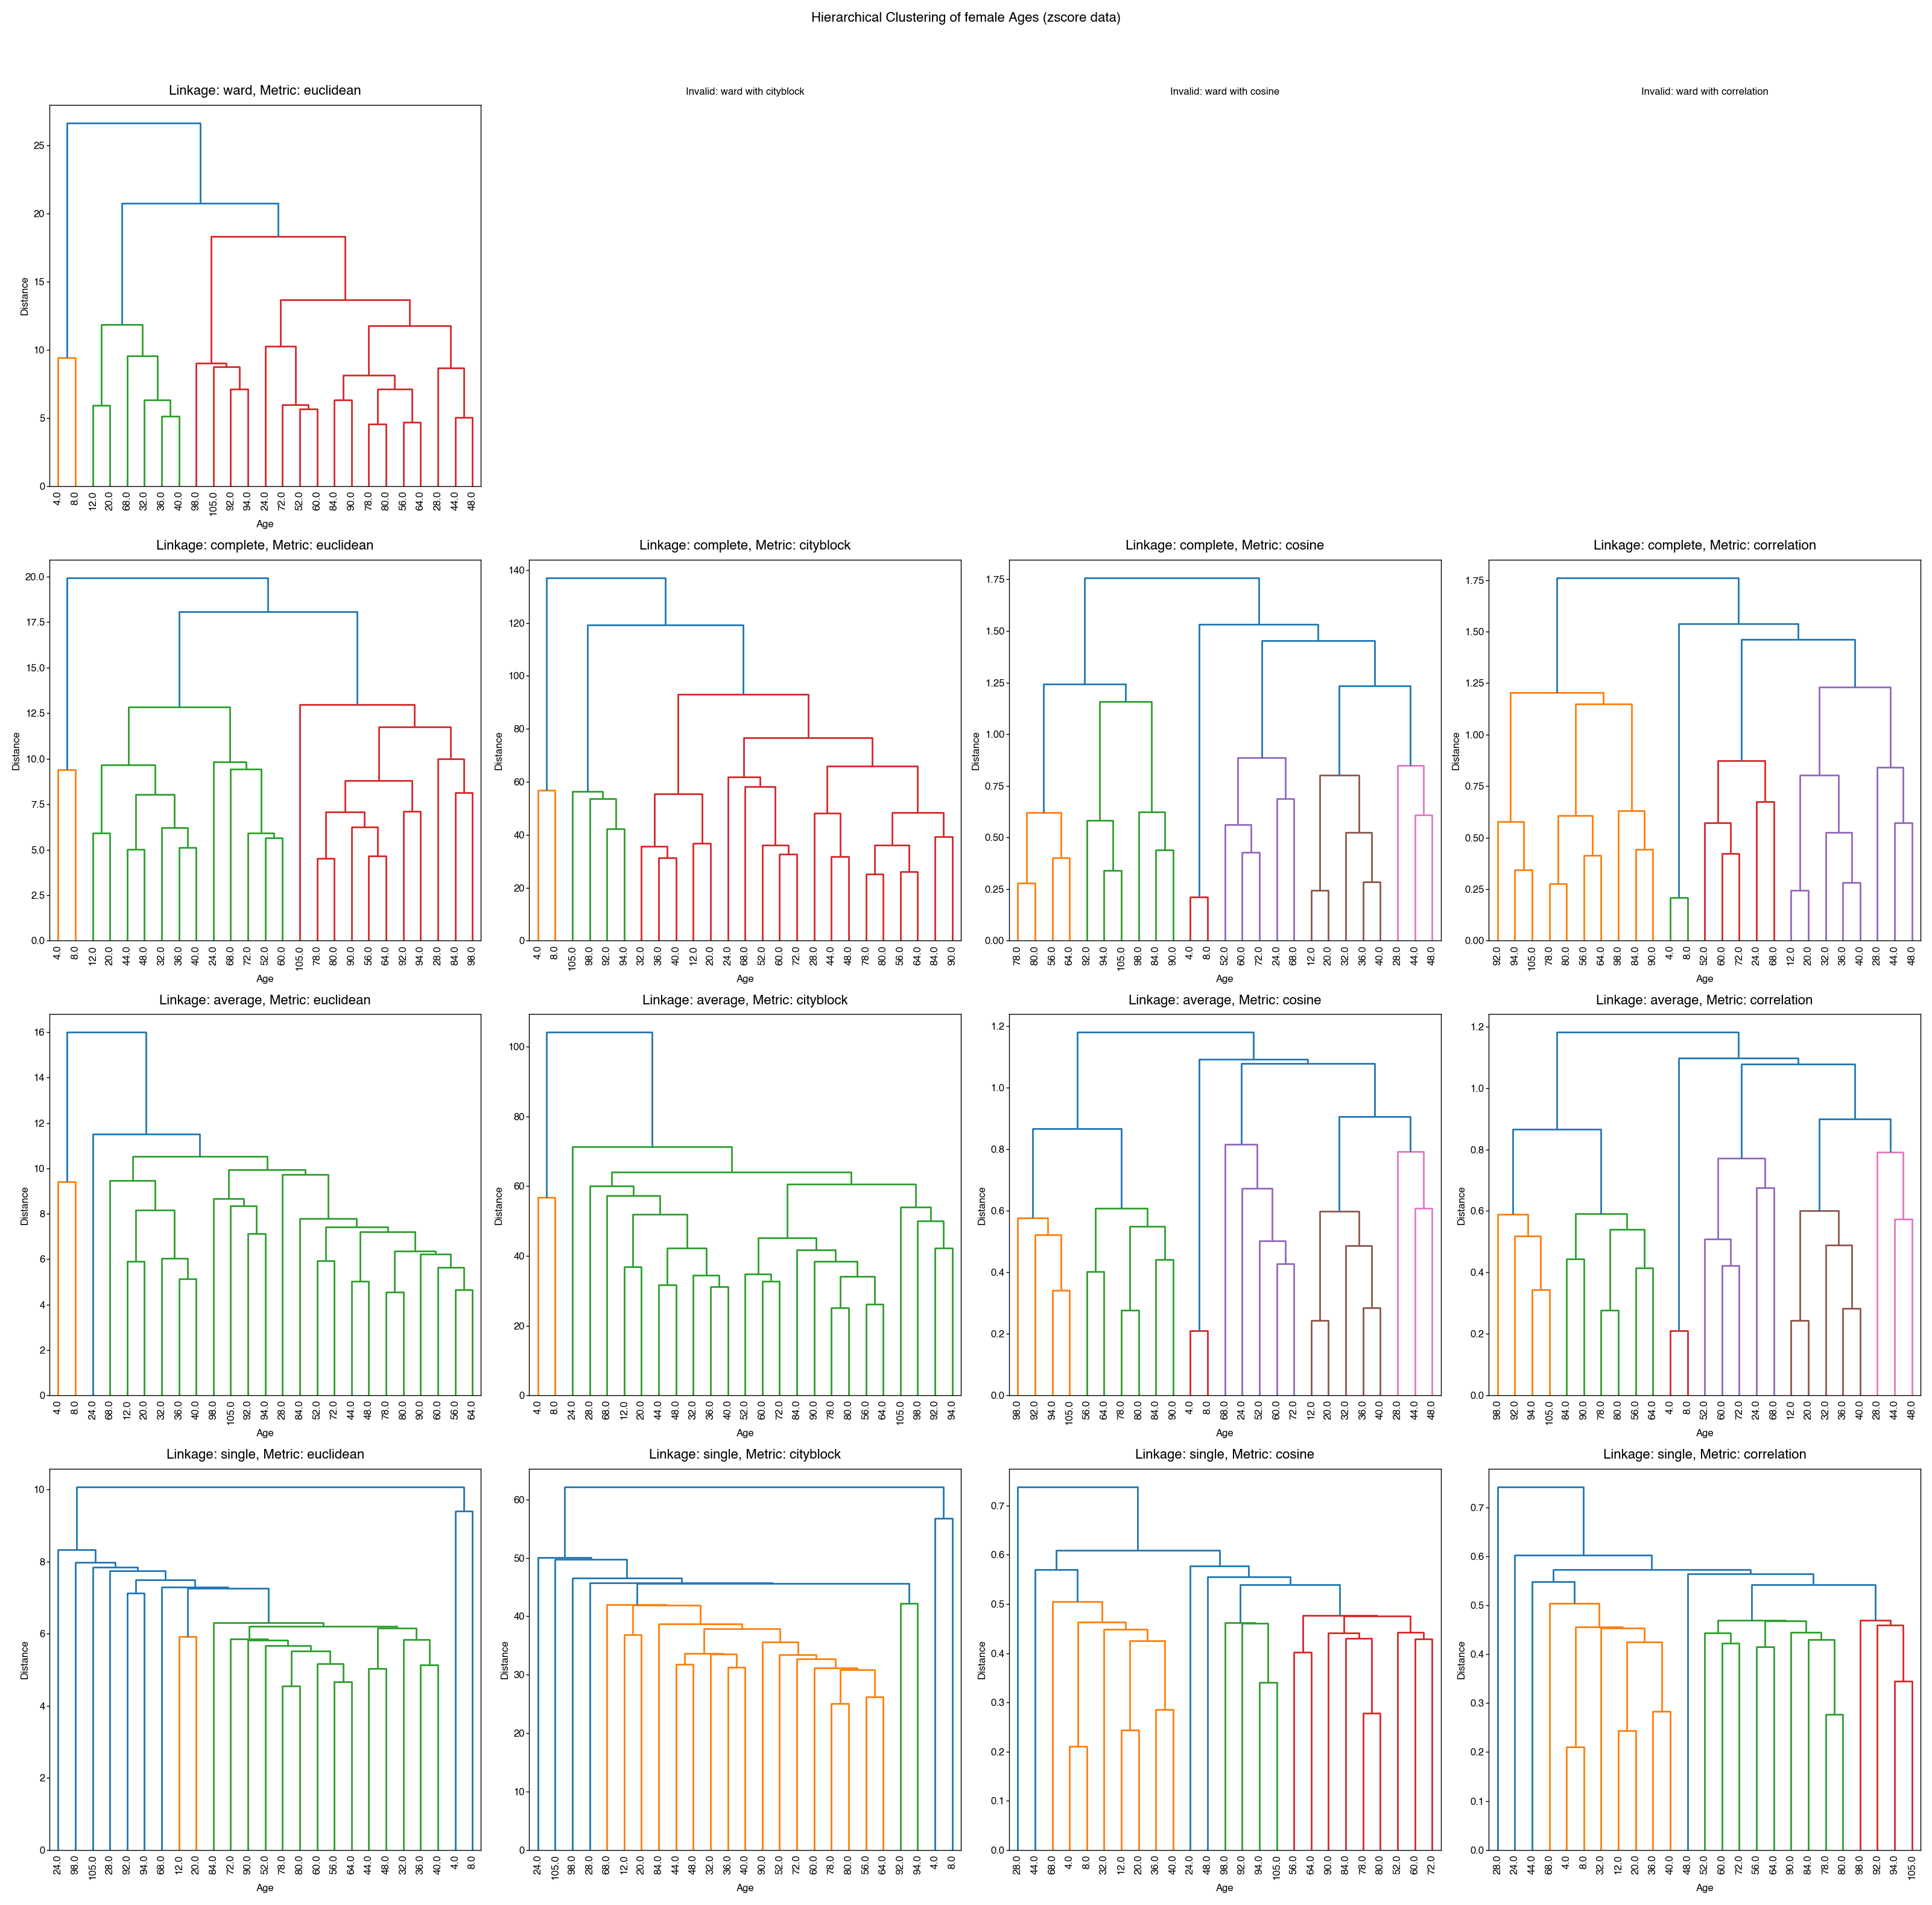

In [10]:
from scipy.cluster.hierarchy import dendrogram, linkage
dataframes = [avg_f_df, avg_f_log, avg_f_norm, avg_z_f]
data_types = ['raw', 'log', 'min/max', 'zscore']


# Parameters for hierarchical clustering
linkage_methods = ['ward', 'complete', 'average', 'single']
distance_metrics = ['euclidean', 'cityblock', 'cosine', 'correlation']

for df, data_type in zip(dataframes, data_types):
    X = df.values

    # Set up the subplot grid
    fig, axes = plt.subplots(len(linkage_methods), len(distance_metrics), figsize=(16, 16))
    fig.suptitle(f'Hierarchical Clustering of female Ages ({data_type} data)', fontsize=8)

    for i, method in enumerate(linkage_methods):
        for j, metric in enumerate(distance_metrics):
            if method == 'ward' and metric != 'euclidean':
                axes[i, j].axis('off')  # Turn off the axis if the combination is invalid
                axes[i, j].set_title(f'Invalid: {method} with {metric}', fontsize=6)
            else:
                ax = axes[i, j]
                if metric in ['cityblock', 'cosine', 'correlation']:
                    dists = pdist(X, metric=metric)
                    Z = linkage(dists, method=method)
                else:
                    Z = linkage(X, method=method, metric=metric)
                dendro = dendrogram(Z, labels=df.index.get_level_values('age'), ax=ax, leaf_rotation=90)
                ax.set_title(f'Linkage: {method}, Metric: {metric}', fontsize=8)
                ax.set_xlabel('Age', fontsize=6)
                ax.set_ylabel('Distance', fontsize=6)
                ax.tick_params(axis='x', labelsize=6)
                ax.tick_params(axis='y', labelsize=6)

    # Adjust layout
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()